# MOYRA (Multi bOdy dYnamics fRAmework)
With this library you can create symbolic equations of motion for low-order multi body systems. These systems can then be converted into numerical equations to be intergrated in either python or MATLAB.
It is built untop of the sympy package and many of the operations will feel familer to users of the package.

The package was initially designed for aeroelastic modelling and as such there are certain elements (such as aero forces) which are specific to this use case, however this tool should be useful to anyone wanting to create low-order equations of motion, without the need for any numerical differentiation. 

## Installation
To install simply run 

```
pip install moyra
```
## Build

To build this package run the following command
```
python setup.py sdist bdist_wheel
```
the README.md can be updated from the jupyter notebook using the command
```
jupyter nbconvert --to markdown readme.ipynb   
```

## Local Development

To install this pacakge locally clone in developer mode run either of the following commands

```
pip install -e <directory of the setup.py file>
```
```
python <directory of the setup.py file>/setup.py develop
```
This will install the package locally but respond to local file changes.

## Examples
Examples can be found in the examples folder in the github repository

## Getting Started - A Double Pendulum Example

In this section we will derive the equations of motion for a double pendulum

Firstly we need to import moyra

In [1]:
import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

moyra is built upon 3 simple constructs

### 1. Parameters

model parameters are used to define the symbols used in the generateion of the EoM. The primary class is 'ModelParameters' which can be used to collect all the parameters used.
The 'DynamicModel' static constructer is availible to create the nessacary state paraemters

In [2]:
DoFs = 2          # total degrees of freedom
p = ma.DynamicModelParameters(DoFs)
vars(p).keys()

dict_keys(['qs', 'q', 'qd', 'qdd', 'x'])

from the output we can see 5 parameters have been created, this are:
- p.qs - the number of DoFs
- p.q - the DoFs
- p.qd - the first derivative of the DoFs
- p.qdd - the second derivative of the DoFs
- p.x - the state space representation of the DoFs [p.q[0],p.qd[0],...,p.q[n],p.pd[n]]

In [3]:
p.x

Matrix([
[               q0(t)],
[Derivative(q0(t), t)],
[               q1(t)],
[Derivative(q1(t), t)]])

next we will add the nesscacary parameters for our double pendulum
(note we add a value to each symbol - this is used later to inject numerical values on each paramter)

In [4]:
p.L_1 = ma.ModelSymbol(value = 1, string = 'L_1') # the length from the origin to the first mass
p.L_2 = ma.ModelSymbol(value = 1, string = 'L_2') # the ength from the 1st to the 2nd mass

p.m_1 = ma.ModelSymbol(value = 1, string = 'm_1') # the mass of mass 1
p.m_2 = ma.ModelSymbol(value = 1, string = 'm_2') # the mass of mass 2
p.g  = ma.ModelSymbol(value = 9.81, string = 'g') # gravity

### 2. Reference Frames
all motion in moyra is defined by the motion of reference frames relative to each other. 
Starting from a base frame you can build up rotations and translations to get to the required reference frames. In this example a frames is constructed for each mass

In [5]:
m_1_frame = ma.HomogenousTransform().R_x(p.q[0]).Translate(0,0,-p.L_1)
m_2_frame = m_1_frame.R_x(p.q[1]).Translate(0,0,-p.L_2)

### 3. Elements
an element is any body that has either: kinetic energy, potential energy or an assciated rayleigh dissaptive function (a damper...). moyra has built in the abilty to generate:
- point mass
- point mass with moments of inertia
- springs
- dampers
- custom elements (user defined K.E, P.E and damping terms)
for this example we will create two point mass elements

In [6]:
# Generate Rigid Elements
M_1 = ele.RigidElement.point_mass(m_1_frame,p.m_1,gravityPotential=True)
M_2 = ele.RigidElement.point_mass(m_2_frame,p.m_2,gravityPotential=True)

## Creating the EoMs

All create elements (and external forces) can then be combined and used to create the Equations of motion (using the euler-lagrange method)

In [7]:
# Generate the Equations of Motion
sm = ma.SymbolicModel.FromElementsAndForces(p,[M_1,M_2])

The resulting EoM are of the form:
$$M(q,\dot{q})\ddot{q} + f(q,\dot{q}) = Q(q,\dot{q}) $$
where in our case the M and f matrices are

(the first few lines are to get derivatives to print nicely)

In [8]:
import sympy.physics.mechanics as me
me.mechanics_printing()
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
sm.M

⎡  2        2                             2                          2   ⎤
⎢L₁ ⋅m₁ + L₁ ⋅m₂ + 2⋅L₁⋅L₂⋅m₂⋅cos(q₁) + L₂ ⋅m₂  L₁⋅L₂⋅m₂⋅cos(q₁) + L₂ ⋅m₂⎥
⎢                                                                        ⎥
⎢                               2                          2             ⎥
⎣          L₁⋅L₂⋅m₂⋅cos(q₁) + L₂ ⋅m₂                     L₂ ⋅m₂          ⎦

In [9]:
sm.f

⎡                                               2                             
⎢-2⋅L₁⋅L₂⋅m₂⋅sin(q₁)⋅q₀̇⋅q₁̇ - L₁⋅L₂⋅m₂⋅sin(q₁)⋅q₁̇  + L₁⋅g⋅m₁⋅sin(q₀) - g⋅m₂⋅
⎢                                                                             
⎢                                                                             
⎣     -L₁⋅L₂⋅m₂⋅sin(q₁)⋅q₀̇⋅q₁̇ + L₂⋅g⋅m₂⋅(sin(q₀)⋅cos(q₁) + sin(q₁)⋅cos(q₀)) 

                                                   ⎤
(-L₁⋅sin(q₀) - L₂⋅(sin(q₀)⋅cos(q₁) + sin(q₁)⋅cos(q₀)))⎥
                                                   ⎥
   ⎛                  2                      ⎞     ⎥
- m₂⋅⎝- L₁⋅L₂⋅sin(q₁)⋅q₀̇  - L₁⋅L₂⋅sin(q₁)⋅q₀̇⋅q₁̇⎠     ⎦

We can then either convert these matricies into a numeric form (python or MATLAB) or save them to file, which we will do here

In [10]:
# save symbolic matrices to a python file, then load it again
sm.to_file(p,'tmp_dp_eom.py')
(sm,p) = ma.SymbolicModel.from_file('tmp_dp_eom.py')



## Save to a MATLAB file 
The following function creates 4 files in the specified directory:
- get_f.m, get_M.m, get_Q.m : matlab functions the generate the f,M and Q matricies.
  These functions take two arguments:
  - U: the state vector p.x
  - p: an instance of the parameter class (see the next file)
- Parameters.m: a matlab class with all the parameters and default values. Allowing you to easily change parameters in MATLAB simulations

In [11]:
sm.to_matlab_file(p,file_dir='')

## Convert to numpy matrices
The following code converts the symbolic matrices to numpy matrices

In [12]:
nm  = ma.NumericModel.from_SymbolicModel(p,sm)
vars(nm)

{'ExtForces': <function _lambdifygenerated(_Dummy_44, _Dummy_45, t)>,
 'M': <function _lambdifygenerated(_Dummy_50, _Dummy_51)>,
 'f': <function _lambdifygenerated(_Dummy_56, _Dummy_57)>,
 'pe': <function _lambdifygenerated(_Dummy_62, _Dummy_63)>,
 'ke': <function _lambdifygenerated(_Dummy_68, _Dummy_69)>}

This instance of the 'NumericModel' class has 5 parameters as shown above. It also has the method 'nm.deriv(x,tup,t)' to calculate the derivative of the state vector.
All these functions have the same signature (x,tup,[t]). Where t is only for the ExtForces and deriv functions. Theses variables are:
- x: the state vector as a list
- tup: a tuple of all the values for each parameter which can be generated by running
```
tup = p.GetNumericTuple(x,t,ignore=[])
```
- t: the time 

As an example let us find the derivate of our double pendulum from the following initial positon.

In [13]:
import numpy as np
x = [0,0,np.deg2rad(45),0]
t = 0
tup = p.GetNumericTuple(x,t)
print(nm.deriv(x,tup,t))

(0, 3.2700000000000005, 0, -12.51895669792004)


## Numerical Integration
By utilising scipy we can intregrate this 

In [14]:
from scipy.integrate import solve_ivp
end_time = 10
t = np.linspace(0, end_time, (end_time*100)+1)
y_data = solve_ivp(lambda t, y: nm.deriv(y,p.GetNumericTuple(y, t),t), (0, end_time), x,t_eval = t)
    

Text(0, 0.5, 'angle [deg]')

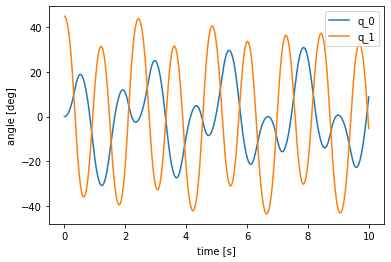

In [15]:
import matplotlib.pyplot as plt
plt.plot(y_data.t,np.rad2deg(y_data.y[0,:]))
plt.plot(y_data.t,np.rad2deg(y_data.y[2,:]))
plt.legend(['q_0','q_1'])
plt.xlabel('time [s]')
plt.ylabel('angle [deg]')

## Time dependence
From the above example it is not clear why deriv, ExtForces and GetNumericTuple have a time parameter.

Regarding Extforces custom functions can replace / enhance this function.

Regarding GetNumericTuple the value of parameters can by replaced with a function of the following signature (x,t). So if for example we wanted
 the mass of m_2 to vary over the first 5 seconds (as if water was draining out of it) we could do the following...

In [16]:
print(p.m_1.value)

1


In [17]:
def leaky_ball(x,t):
    if t<5:
        return 1-(t/5)*0.9
    else:
        return 0.1
p.m_2.value = leaky_ball

Text(0, 0.5, 'angle [deg]')

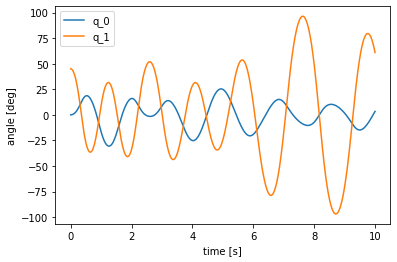

In [18]:
y_data = solve_ivp(lambda t, y: nm.deriv(y,p.GetNumericTuple(y, t),t), (0, 10), x,t_eval = t)
plt.plot(y_data.t,np.rad2deg(y_data.y[0,:]))
plt.plot(y_data.t,np.rad2deg(y_data.y[2,:]))
plt.legend(['q_0','q_1'])
plt.xlabel('time [s]')
plt.ylabel('angle [deg]')